# Grad-CAM

In [2]:
import numpy as np
from monai.networks.nets import DenseNet121
import torch
import torch.nn as nn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = DenseNet121(spatial_dims=2, in_channels=10,
                    out_channels=1, dropout_prob=0.0).cuda()

checkpoint_path = "/media/andres/T7 Shield1/UCAN_project/Results/regression/Experiment_1/CV_0/Network_Weights/best_model_847.pth.tar"
checkpoint = torch.load(checkpoint_path)
model.load_state_dict(checkpoint['net'])



<All keys matched successfully>

In [3]:
import torch
from monai.data import Dataset, DataLoader
from monai.transforms import Compose, LoadImage, ToTensor, ScaleIntensity
from tqdm import tqdm
import pandas as pd

class ImageDataset(Dataset):
    def __init__(self, SUV_MIP_files, SUV_bone_files, SUV_lean_files, SUV_adipose_files, SUV_air_files, CT_MIP_files, CT_bone_files, CT_lean_files, CT_adipose_files, CT_air_files, labels):
        self.SUV_MIP_files = SUV_MIP_files
        self.SUV_bone_files = SUV_bone_files
        self.SUV_lean_files = SUV_lean_files
        self.SUV_adipose_files = SUV_adipose_files
        self.SUV_air_files = SUV_air_files
        self.CT_MIP_files = CT_MIP_files
        self.CT_bone_files = CT_bone_files
        self.CT_lean_files = CT_lean_files
        self.CT_adipose_files = CT_adipose_files
        self.CT_air_files = CT_air_files
        self.labels = labels
        self.transform = Compose(
                                    [
                                        LoadImage(image_only=True, dtype=float), 
                                        ToTensor(),
                                        ScaleIntensity(minv=0, maxv=1)
                                    ]
                                )
    def __len__(self):
        return len(self.SUV_MIP_files)

    def __getitem__(self, index):
        SUV_MIP_path = self.SUV_MIP_files[index]
        SUV_bone_path = self.SUV_bone_files[index]
        SUV_lean_path = self.SUV_lean_files[index]
        SUV_adipose_path = self.SUV_adipose_files[index]
        SUV_air_path = self.SUV_air_files[index]
        CT_MIP_path = self.CT_MIP_files[index]
        CT_bone_path = self.CT_bone_files[index]
        CT_lean_path = self.CT_lean_files[index]
        CT_adipose_path = self.CT_adipose_files[index]
        CT_air_path = self.CT_air_files[index]        
        label = self.labels[index]

        # Load and transform the images
        SUV_MIP = self.transform(SUV_MIP_path)
        SUV_bone = self.transform(SUV_bone_path)
        SUV_lean = self.transform(SUV_lean_path)
        SUV_adipose = self.transform(SUV_adipose_path)
        SUV_air = self.transform(SUV_air_path)
        CT_MIP = self.transform(CT_MIP_path)
        CT_bone = self.transform(CT_bone_path)
        CT_lean = self.transform(CT_lean_path)
        CT_adipose = self.transform(CT_adipose_path)
        CT_air = self.transform(CT_air_path)

        # Concatenate the images along the channel dimension
        SUV_MIP_new = torch.unsqueeze(SUV_MIP, 0)
        SUV_bone_new = torch.unsqueeze(SUV_bone, 0)
        SUV_lean_new = torch.unsqueeze(SUV_lean, 0)
        SUV_adipose_new = torch.unsqueeze(SUV_adipose, 0)
        SUV_air_new = torch.unsqueeze(SUV_air, 0)
        CT_MIP_new = torch.unsqueeze(CT_MIP, 0)
        CT_bone_new = torch.unsqueeze(CT_bone, 0)
        CT_lean_new = torch.unsqueeze(CT_lean, 0)
        CT_adipose_new = torch.unsqueeze(CT_adipose, 0)
        CT_air_new = torch.unsqueeze(CT_air, 0)

        multi_channel_input = torch.cat((SUV_MIP_new, SUV_bone_new, SUV_lean_new, SUV_adipose_new, SUV_air_new, CT_MIP_new, CT_bone_new, CT_lean_new, CT_adipose_new, CT_air_new), dim=0)
        #multi_channel_input = torch.cat((CT_MIP_new, CT_bone_new, CT_lean_new, CT_adipose_new, CT_air_new), dim=0)
        #multi_channel_input = torch.cat((SUV_MIP_new, SUV_bone_new, SUV_lean_new, SUV_adipose_new, SUV_air_new), dim=0)
        #multi_channel_input = torch.cat((SUV_MIP_new, SUV_MIP_new))

        return multi_channel_input, label


def prepare_data(df_train, batch_size, shuffle=None, label=None):
    if shuffle==True:
        df_train_shuffled = df_train.sample(frac=1).reset_index(drop=True)
    elif shuffle==False:
        df_train_shuffled = df_train

    SUV_MIP_train = df_train_shuffled['SUV_MIP'].tolist()
    SUV_bone_train = df_train_shuffled['SUV_bone'].tolist()
    SUV_lean_train = df_train_shuffled['SUV_lean'].tolist()
    SUV_adipose_train = df_train_shuffled['SUV_adipose'].tolist()
    SUV_air_train = df_train_shuffled['SUV_air'].tolist()
    CT_MIP_train = df_train_shuffled['CT_MIP'].tolist()
    CT_bone_train = df_train_shuffled['CT_bone'].tolist()
    CT_lean_train = df_train_shuffled['CT_lean'].tolist()
    CT_adipose_train = df_train_shuffled['CT_adipose'].tolist()
    CT_air_train = df_train_shuffled['CT_air'].tolist()

    if label == "sex":
        label_train = df_train_shuffled['sex'].tolist()
    if label == "diagnosis":
        label_train = df_train_shuffled['diagnosis'].tolist()
    elif label == "patient_age":
        label_train = df_train_shuffled['patient_age'].tolist()
    elif label == "MTV":
        label_train = df_train_shuffled['MTV (ml)'].tolist()
    elif label == "lean_volume":
        label_train = df_train_shuffled['lean_volume (L)'].tolist()

    train_files = [
        {"SUV_MIP": SUV_MIP_name, "SUV_bone": SUV_bone_name, "SUV_lean": SUV_lean_name, "SUV_adipose": SUV_adipose_name, "SUV_air": SUV_air_name, 
        "CT_MIP": CT_MIP_name, "CT_bone": CT_bone_name, "CT_lean": CT_lean_name, "CT_adipose": CT_adipose_name, "CT_air": CT_air_name, "label": label_name}
        for SUV_MIP_name, SUV_bone_name, SUV_lean_name, SUV_adipose_name, SUV_air_name, CT_MIP_name, CT_bone_name, CT_lean_name, CT_adipose_name, CT_air_name, label_name in 
        zip(SUV_MIP_train, SUV_bone_train, SUV_lean_train, SUV_adipose_train, SUV_air_train, CT_MIP_train, CT_bone_train, CT_lean_train, CT_adipose_train, CT_air_train, label_train)
    ]

    train_ds = ImageDataset(SUV_MIP_train, SUV_bone_train, SUV_lean_train, SUV_adipose_train, SUV_air_train, CT_MIP_train, CT_bone_train, CT_lean_train, CT_adipose_train, CT_air_train, label_train)
    train_loader = DataLoader(train_ds, batch_size=1, shuffle=True, num_workers=0)

    return train_files, train_loader

K = 10
k = 0

df = pd.read_excel("/media/andres/T7 Shield1/UCAN_project/dataset_for_model_regression_training.xlsx")
#df = df[df["diagnosis"]!="NEGATIVE"].reset_index(drop=True)
df_rot_mips_collages = pd.read_excel("/media/andres/T7 Shield1/UCAN_project/dataset_for_model_regression_training.xlsx")
df_sorted = df_rot_mips_collages.sort_values(by="patient_ID")

df_sorted["scan_date"] = df_sorted["scan_date"].astype(str)
df_sorted["unique_pat_ID_scan_date"] = df_sorted["patient_ID"] + "_" + df_sorted["scan_date"]


factor = round(df.shape[0]/K)
if k == (K - 1):
    patients_for_val = df_sorted[factor*k:].patient_ID.tolist()
    df_val = df_sorted[df_sorted.patient_ID.isin(patients_for_val)].reset_index(drop=True)
else:
    patients_for_val = df_sorted[factor*k:factor*k+factor].patient_ID.tolist()
    df_val = df_sorted[df_sorted.patient_ID.isin(patients_for_val)].reset_index(drop=True)

df_train = df[~df.patient_ID.isin(df_val.patient_ID)].reset_index(drop=True)

df_train_new = df_train
df_val_new = df_val

unique_patient = np.unique(df_val_new["unique_pat_ID_scan_date"])
np.random.shuffle(unique_patient)

for unique_patient in tqdm(unique_patient):
    df_temp = df_val_new[df_val_new["unique_pat_ID_scan_date"]==unique_patient].reset_index(drop=True)
    #df_temp = df_val_new[df_val_new["scan_date"]=="03-27-2005-NA-PET-CT Ganzkoerper  primaer mit KM-38725"].reset_index(drop=True)
    
    pat_id = np.unique(df_temp["patient_ID"])
    #val_files, val_loader = prepare_data(args, df_temp, shuffle=False, label="age")
    val_files, val_loader = prepare_data(df_temp, 1, shuffle=True, label="patient_age")
    
    for inputs, labels in val_loader:
        model.eval()
        inputs, labels = inputs.cuda(), labels.cuda()

100%|██████████| 193/193 [00:31<00:00,  6.20it/s]


In [60]:
inputs.shape

torch.Size([1, 10, 580, 512])

In [4]:
#Regression
# Define Grad-CAM class
class GradCAM:
    def __init__(self, model, layers):
        self.model = model
        self.layers = layers
        self.gradients = []

        def backward_hook(module, grad_input, grad_output):
            self.gradients.append(grad_output[0])

        for layer in self.layers:
            layer.register_backward_hook(backward_hook)

    def generate_heatmap(self, input_tensor):
        self.model.zero_grad()
        output = self.model(input_tensor)
        output.backward()

        heatmaps = []
        for gradient in self.gradients:
            pooled_gradient = torch.mean(gradient, dim=[2, 3], keepdim=True)
            heatmap = (pooled_gradient * gradient).sum(dim=1, keepdim=True)
            heatmap = nn.functional.relu(heatmap)
            heatmap /= heatmap.max()
            heatmaps.append(heatmap)

        return heatmaps

In [33]:
#Classification 
class GradCAM:
    def __init__(self, model, layers):
        self.model = model
        self.layers = layers
        self.gradients = []

        def backward_hook(module, grad_input, grad_output):
            self.gradients.append(grad_output[0])

        for layer in self.layers:
            layer.register_backward_hook(backward_hook)

    def generate_heatmap(self, input_tensor, class_idx=None):
        self.model.zero_grad()
        output = self.model(input_tensor)

        if class_idx is None:
            class_idx = torch.argmax(output, dim=1)  # Use the predicted class

        one_hot = torch.zeros_like(output)
        one_hot[:, class_idx] = 1

        output.backward(gradient=one_hot)

        heatmaps = []
        for gradient in self.gradients:
            pooled_gradient = torch.mean(gradient, dim=[2, 3], keepdim=True)
            heatmap = (pooled_gradient * gradient).sum(dim=1, keepdim=True)
            heatmap = nn.functional.relu(heatmap)
            heatmap /= heatmap.max()
            heatmaps.append(heatmap)

        return heatmaps

In [5]:
layers_to_visualize = [model.features.transition3, model.features.transition2,
                       model.features.transition1, model.features.conv0]


In [6]:
# Create Grad-CAM instance
grad_cam = GradCAM(model, layers_to_visualize)

In [7]:
# Generate and visualize heatmaps for each layer
heatmaps = grad_cam.generate_heatmap(inputs)

/home/andres/anaconda3/envs/UCANProject/lib/python3.11/site-packages/torch/nn/modules/module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


In [8]:
# Resize heatmaps to match the original image size
resized_heatmaps = []
for heatmap in heatmaps:
    resized_heatmap = nn.functional.interpolate(heatmap, size=(580, 512), mode='bilinear', align_corners=False)
    resized_heatmaps.append(resized_heatmap)

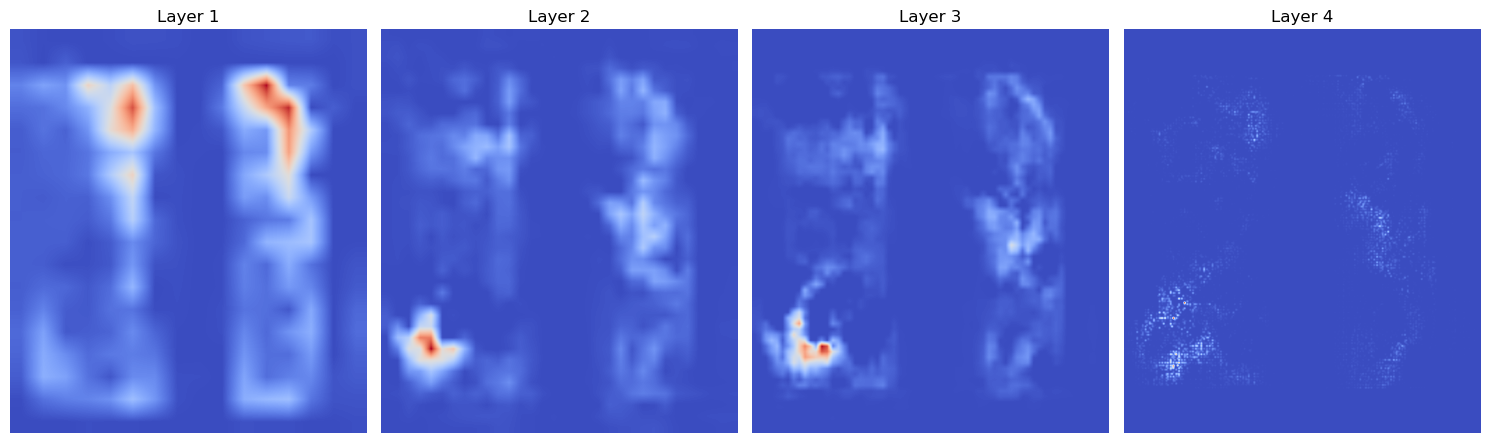

In [9]:
# Plot the heatmaps
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 6))
for i, (layer, heatmap) in enumerate(zip(layers_to_visualize, resized_heatmaps)):
    plt.subplot(1, len(layers_to_visualize), i + 1)
    plt.imshow(heatmap[0, 0].cpu().detach().numpy(), cmap="coolwarm")
    plt.title(f'Layer {i + 1}')
    plt.axis('off')

plt.tight_layout()
plt.show()

In [10]:
resized_heatmaps[0].shape

torch.Size([1, 1, 580, 512])

In [11]:
import os
reshaped_collages = pd.read_excel("/media/andres/T7 Shield1/UCAN_project/dataset_for_model_regression_training.xlsx")  

K = 10
k = 0

df_sorted = reshaped_collages.sort_values(by="patient_ID")

df_sorted["scan_date"] = df_sorted["scan_date"].astype(str)
df_sorted["unique_pat_ID_scan_date"] = df_sorted["patient_ID"] + "_" + df_sorted["scan_date"]


factor = round(df.shape[0]/K)
if k == (K - 1):
    patients_for_val = df_sorted[factor*k:].patient_ID.tolist()
    df_val = df_sorted[df_sorted.patient_ID.isin(patients_for_val)].reset_index(drop=True)
else:
    patients_for_val = df_sorted[factor*k:factor*k+factor].patient_ID.tolist()
    df_val = df_sorted[df_sorted.patient_ID.isin(patients_for_val)].reset_index(drop=True)

df_train = df[~df.patient_ID.isin(df_val.patient_ID)].reset_index(drop=True)

df_train_new = df_train
df_val_new = df_val

unique_patient = np.unique(df_val_new["unique_pat_ID_scan_date"])
np.random.shuffle(unique_patient)

for unique_patient in tqdm(unique_patient):
    df_temp = df_val_new[df_val_new["unique_pat_ID_scan_date"]==unique_patient].reset_index(drop=True)
    #df_temp = df_val_new[df_val_new["scan_date"]=="03-27-2005-NA-PET-CT Ganzkoerper  primaer mit KM-38725"].reset_index(drop=True)
    
    pat_id = np.unique(df_temp["patient_ID"])
    #val_files, val_loader = prepare_data(args, df_temp, shuffle=False, label="age")
    val_files, val_loader = prepare_data(df_temp, 1, shuffle=True, label="patient_age")
    
    for inputs, labels in val_loader:
        model.eval()
        inputs, labels = inputs.cuda(), labels.cuda()

        layers_to_visualize = [model.features.transition3, model.features.transition2, model.features.transition1, model.features.conv0]

        # Generate and visualize heatmaps for each layer
        heatmaps = grad_cam.generate_heatmap(inputs)
        
        # Resize heatmaps to match the original image size
        resized_heatmaps = []
        for heatmap in heatmaps:
            resized_heatmap = nn.functional.interpolate(heatmap, size=(580, 512), mode='bilinear', align_corners=False)
            resized_heatmaps.append(resized_heatmap)

        i = inputs[0,0,:,:].data.cpu().numpy()
        h = resized_heatmaps[0][0,0,:,:].data.cpu().numpy()
        # Normalize the heatmap values
        heatmap_normalized = h / np.max(h)

        # Set a transparency factor for the heatmap overlay
        alpha = 0.7

        # Overlay the heatmap on the image using element-wise addition and transparency
        overlayed_image = alpha * heatmap_normalized + (1 - alpha) * i

        # Clip values to stay within [0, 1] range
        overlayed_image = np.clip(overlayed_image, 0, 1)

        output_path = "/media/andres/T7 Shield1/UCAN_project/Results/GradCam_analysis/"
        # save_path = os.path.join(output_path, pat_id[0])

        if not os.path.exists(output_path):
            os.makedirs(output_path)

        plt.imshow(overlayed_image, cmap="coolwarm")
        #plt.imshow(overlayed_image, cmap="RdYlBu_r")

        plt.savefig(output_path + f"/gradients_overlap_{pat_id[0]}.jpg", dpi=400)
        #plt.show()
        #plt.imshow(i, cmap="gray")

        # plt.imshow(i, cmap="gray")
        # plt.imshow(overlayed_image, cmap="RdYlBu_r")

        # plt.savefig(save_path + "/img.jpg", dpi=400)
        print(pat_id)

  0%|          | 0/193 [00:00<?, ?it/s]/home/andres/anaconda3/envs/UCANProject/lib/python3.11/site-packages/torch/nn/modules/module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
  1%|          | 1/193 [00:00<02:16,  1.41it/s]

['npr151953219609']


/home/andres/anaconda3/envs/UCANProject/lib/python3.11/site-packages/torch/nn/modules/module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
  1%|          | 2/193 [00:01<02:21,  1.35it/s]

['npr203979873997']


/home/andres/anaconda3/envs/UCANProject/lib/python3.11/site-packages/torch/nn/modules/module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
  2%|▏         | 3/193 [00:02<02:34,  1.23it/s]

['npr138028683671']


/home/andres/anaconda3/envs/UCANProject/lib/python3.11/site-packages/torch/nn/modules/module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
  2%|▏         | 4/193 [00:03<02:51,  1.10it/s]

['npr144927447784']


/home/andres/anaconda3/envs/UCANProject/lib/python3.11/site-packages/torch/nn/modules/module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
  3%|▎         | 5/193 [00:04<03:13,  1.03s/it]

['npr205346582030']


/home/andres/anaconda3/envs/UCANProject/lib/python3.11/site-packages/torch/nn/modules/module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
  3%|▎         | 6/193 [00:06<03:45,  1.21s/it]

['npr144131901343']


/home/andres/anaconda3/envs/UCANProject/lib/python3.11/site-packages/torch/nn/modules/module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
  4%|▎         | 7/193 [00:07<04:16,  1.38s/it]

['npr173022748632']


/home/andres/anaconda3/envs/UCANProject/lib/python3.11/site-packages/torch/nn/modules/module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
  4%|▍         | 8/193 [00:09<04:36,  1.50s/it]

['npr136457009354']


/home/andres/anaconda3/envs/UCANProject/lib/python3.11/site-packages/torch/nn/modules/module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
  5%|▍         | 9/193 [00:11<04:59,  1.63s/it]

['npr167784356423']


/home/andres/anaconda3/envs/UCANProject/lib/python3.11/site-packages/torch/nn/modules/module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
  5%|▌         | 10/193 [00:13<05:24,  1.77s/it]

['npr165323206667']


/home/andres/anaconda3/envs/UCANProject/lib/python3.11/site-packages/torch/nn/modules/module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
  6%|▌         | 11/193 [00:15<05:48,  1.92s/it]

['npr110222274795']


/home/andres/anaconda3/envs/UCANProject/lib/python3.11/site-packages/torch/nn/modules/module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
  6%|▌         | 12/193 [00:18<06:14,  2.07s/it]

['npr115317263249']


/home/andres/anaconda3/envs/UCANProject/lib/python3.11/site-packages/torch/nn/modules/module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
  7%|▋         | 13/193 [00:20<06:42,  2.24s/it]

['npr137231127717']


/home/andres/anaconda3/envs/UCANProject/lib/python3.11/site-packages/torch/nn/modules/module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
  7%|▋         | 14/193 [00:23<07:10,  2.40s/it]

['npr171602607671']


/home/andres/anaconda3/envs/UCANProject/lib/python3.11/site-packages/torch/nn/modules/module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
  8%|▊         | 15/193 [00:27<07:51,  2.65s/it]

['npr205346582030']


/home/andres/anaconda3/envs/UCANProject/lib/python3.11/site-packages/torch/nn/modules/module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
  8%|▊         | 16/193 [00:30<08:34,  2.91s/it]

['npr123612599830']


/home/andres/anaconda3/envs/UCANProject/lib/python3.11/site-packages/torch/nn/modules/module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
  9%|▉         | 17/193 [00:33<08:48,  3.01s/it]

['npr108162813691']


/home/andres/anaconda3/envs/UCANProject/lib/python3.11/site-packages/torch/nn/modules/module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
  9%|▉         | 18/193 [00:37<09:07,  3.13s/it]

['lpr385705046400']


/home/andres/anaconda3/envs/UCANProject/lib/python3.11/site-packages/torch/nn/modules/module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
 10%|▉         | 19/193 [00:40<09:29,  3.27s/it]

['npr205346582030']


/home/andres/anaconda3/envs/UCANProject/lib/python3.11/site-packages/torch/nn/modules/module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
 10%|█         | 20/193 [00:44<10:15,  3.56s/it]

['npr107605794128']


/home/andres/anaconda3/envs/UCANProject/lib/python3.11/site-packages/torch/nn/modules/module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
 11%|█         | 21/193 [00:48<10:32,  3.67s/it]

['npr167577668669']


/home/andres/anaconda3/envs/UCANProject/lib/python3.11/site-packages/torch/nn/modules/module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
 11%|█▏        | 22/193 [00:53<11:20,  3.98s/it]

['npr205346582030']


/home/andres/anaconda3/envs/UCANProject/lib/python3.11/site-packages/torch/nn/modules/module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
 12%|█▏        | 23/193 [00:58<12:08,  4.28s/it]

['npr107605794128']


/home/andres/anaconda3/envs/UCANProject/lib/python3.11/site-packages/torch/nn/modules/module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
 12%|█▏        | 24/193 [01:03<12:46,  4.54s/it]

['npr194089358707']


/home/andres/anaconda3/envs/UCANProject/lib/python3.11/site-packages/torch/nn/modules/module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
 13%|█▎        | 25/193 [01:08<12:55,  4.61s/it]

['npr203979873997']


/home/andres/anaconda3/envs/UCANProject/lib/python3.11/site-packages/torch/nn/modules/module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
 13%|█▎        | 26/193 [01:13<12:56,  4.65s/it]

['npr203207608845']


/home/andres/anaconda3/envs/UCANProject/lib/python3.11/site-packages/torch/nn/modules/module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
 14%|█▍        | 27/193 [01:18<13:12,  4.78s/it]

['npr151152435400']


/home/andres/anaconda3/envs/UCANProject/lib/python3.11/site-packages/torch/nn/modules/module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
 15%|█▍        | 28/193 [01:24<14:25,  5.24s/it]

['npr205346582030']


/home/andres/anaconda3/envs/UCANProject/lib/python3.11/site-packages/torch/nn/modules/module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
 15%|█▌        | 29/193 [01:30<15:05,  5.52s/it]

['npr130508688944']


/home/andres/anaconda3/envs/UCANProject/lib/python3.11/site-packages/torch/nn/modules/module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
 16%|█▌        | 30/193 [01:36<14:58,  5.51s/it]

['npr196644347217']


/home/andres/anaconda3/envs/UCANProject/lib/python3.11/site-packages/torch/nn/modules/module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
 16%|█▌        | 31/193 [01:42<15:06,  5.60s/it]

['npr151152435400']


/home/andres/anaconda3/envs/UCANProject/lib/python3.11/site-packages/torch/nn/modules/module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
 17%|█▋        | 32/193 [01:48<15:22,  5.73s/it]

['npr106484754818']


/home/andres/anaconda3/envs/UCANProject/lib/python3.11/site-packages/torch/nn/modules/module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
 17%|█▋        | 33/193 [01:54<15:32,  5.83s/it]

['npr151462634697']


/home/andres/anaconda3/envs/UCANProject/lib/python3.11/site-packages/torch/nn/modules/module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
 18%|█▊        | 34/193 [02:00<16:01,  6.05s/it]

['npr123895614736']


/home/andres/anaconda3/envs/UCANProject/lib/python3.11/site-packages/torch/nn/modules/module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
 18%|█▊        | 35/193 [02:07<16:05,  6.11s/it]

['npr133749302026']


/home/andres/anaconda3/envs/UCANProject/lib/python3.11/site-packages/torch/nn/modules/module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
 19%|█▊        | 36/193 [02:13<16:22,  6.26s/it]

['npr146743887112']


/home/andres/anaconda3/envs/UCANProject/lib/python3.11/site-packages/torch/nn/modules/module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
 19%|█▉        | 37/193 [02:20<16:41,  6.42s/it]

['npr113096472044']


/home/andres/anaconda3/envs/UCANProject/lib/python3.11/site-packages/torch/nn/modules/module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
 20%|█▉        | 38/193 [02:27<16:54,  6.55s/it]

['npr132606348913']


/home/andres/anaconda3/envs/UCANProject/lib/python3.11/site-packages/torch/nn/modules/module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
 20%|██        | 39/193 [02:34<17:29,  6.82s/it]

['npr158542658428']


/home/andres/anaconda3/envs/UCANProject/lib/python3.11/site-packages/torch/nn/modules/module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
 21%|██        | 40/193 [02:41<17:41,  6.94s/it]

['npr192198005019']


/home/andres/anaconda3/envs/UCANProject/lib/python3.11/site-packages/torch/nn/modules/module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
 21%|██        | 41/193 [02:49<17:50,  7.04s/it]

['npr142322880550']


/home/andres/anaconda3/envs/UCANProject/lib/python3.11/site-packages/torch/nn/modules/module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
 22%|██▏       | 42/193 [02:57<18:16,  7.26s/it]

['npr158542658428']


/home/andres/anaconda3/envs/UCANProject/lib/python3.11/site-packages/torch/nn/modules/module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
 22%|██▏       | 43/193 [03:04<18:26,  7.38s/it]

['npr170667868768']


/home/andres/anaconda3/envs/UCANProject/lib/python3.11/site-packages/torch/nn/modules/module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
 23%|██▎       | 44/193 [03:13<19:23,  7.81s/it]

['npr102928239238']


/home/andres/anaconda3/envs/UCANProject/lib/python3.11/site-packages/torch/nn/modules/module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
 23%|██▎       | 45/193 [03:22<20:12,  8.19s/it]

['npr152700668490']


/home/andres/anaconda3/envs/UCANProject/lib/python3.11/site-packages/torch/nn/modules/module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
 24%|██▍       | 46/193 [03:31<20:45,  8.47s/it]

['npr123895614736']


/home/andres/anaconda3/envs/UCANProject/lib/python3.11/site-packages/torch/nn/modules/module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
 24%|██▍       | 47/193 [03:40<21:11,  8.71s/it]

['npr192838641968']


/home/andres/anaconda3/envs/UCANProject/lib/python3.11/site-packages/torch/nn/modules/module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
 25%|██▍       | 48/193 [03:50<21:44,  9.00s/it]

['npr205346582030']


/home/andres/anaconda3/envs/UCANProject/lib/python3.11/site-packages/torch/nn/modules/module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
 25%|██▌       | 49/193 [03:59<21:22,  8.91s/it]

['npr112560979849']


/home/andres/anaconda3/envs/UCANProject/lib/python3.11/site-packages/torch/nn/modules/module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
 26%|██▌       | 50/193 [04:08<21:23,  8.97s/it]

['npr181909353576']


/home/andres/anaconda3/envs/UCANProject/lib/python3.11/site-packages/torch/nn/modules/module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
 26%|██▋       | 51/193 [04:17<21:18,  9.00s/it]

['npr205346582030']


/home/andres/anaconda3/envs/UCANProject/lib/python3.11/site-packages/torch/nn/modules/module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
 27%|██▋       | 52/193 [04:26<21:19,  9.07s/it]

['npr137540272318']


/home/andres/anaconda3/envs/UCANProject/lib/python3.11/site-packages/torch/nn/modules/module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
 27%|██▋       | 53/193 [04:36<21:18,  9.13s/it]

['npr151953219609']


/home/andres/anaconda3/envs/UCANProject/lib/python3.11/site-packages/torch/nn/modules/module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
 28%|██▊       | 54/193 [04:45<21:23,  9.23s/it]

['npr205346582030']


/home/andres/anaconda3/envs/UCANProject/lib/python3.11/site-packages/torch/nn/modules/module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
 28%|██▊       | 55/193 [04:55<21:38,  9.41s/it]

['npr150589533418']


/home/andres/anaconda3/envs/UCANProject/lib/python3.11/site-packages/torch/nn/modules/module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
 29%|██▉       | 56/193 [05:05<21:45,  9.53s/it]

['npr175454576662']


/home/andres/anaconda3/envs/UCANProject/lib/python3.11/site-packages/torch/nn/modules/module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
 30%|██▉       | 57/193 [05:15<21:59,  9.70s/it]

['npr167021644105']


/home/andres/anaconda3/envs/UCANProject/lib/python3.11/site-packages/torch/nn/modules/module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
 30%|███       | 58/193 [05:25<22:07,  9.83s/it]

['npr175454576662']


/home/andres/anaconda3/envs/UCANProject/lib/python3.11/site-packages/torch/nn/modules/module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
 31%|███       | 59/193 [05:35<22:22, 10.02s/it]

['npr170845043530']


/home/andres/anaconda3/envs/UCANProject/lib/python3.11/site-packages/torch/nn/modules/module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
 31%|███       | 60/193 [05:46<22:41, 10.23s/it]

['npr133749302026']


/home/andres/anaconda3/envs/UCANProject/lib/python3.11/site-packages/torch/nn/modules/module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
 32%|███▏      | 61/193 [05:57<22:50, 10.38s/it]

['npr134758508773']


/home/andres/anaconda3/envs/UCANProject/lib/python3.11/site-packages/torch/nn/modules/module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
 32%|███▏      | 62/193 [06:07<22:43, 10.41s/it]

['npr203979873997']


/home/andres/anaconda3/envs/UCANProject/lib/python3.11/site-packages/torch/nn/modules/module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
 33%|███▎      | 63/193 [06:18<22:30, 10.39s/it]

['npr100169878450']


/home/andres/anaconda3/envs/UCANProject/lib/python3.11/site-packages/torch/nn/modules/module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
 33%|███▎      | 64/193 [06:28<22:23, 10.41s/it]

['npr132606348913']


/home/andres/anaconda3/envs/UCANProject/lib/python3.11/site-packages/torch/nn/modules/module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
 34%|███▎      | 65/193 [06:39<22:29, 10.54s/it]

['npr137231127717']


/home/andres/anaconda3/envs/UCANProject/lib/python3.11/site-packages/torch/nn/modules/module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
 34%|███▍      | 66/193 [06:50<22:38, 10.70s/it]

['npr205346582030']


/home/andres/anaconda3/envs/UCANProject/lib/python3.11/site-packages/torch/nn/modules/module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
 35%|███▍      | 67/193 [07:01<22:47, 10.85s/it]

['npr110222274795']


/home/andres/anaconda3/envs/UCANProject/lib/python3.11/site-packages/torch/nn/modules/module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
 35%|███▌      | 68/193 [07:13<22:58, 11.03s/it]

['lpr884752331885']


/home/andres/anaconda3/envs/UCANProject/lib/python3.11/site-packages/torch/nn/modules/module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
 36%|███▌      | 69/193 [07:24<23:07, 11.19s/it]

['npr170667868768']


/home/andres/anaconda3/envs/UCANProject/lib/python3.11/site-packages/torch/nn/modules/module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
 36%|███▋      | 70/193 [07:36<23:24, 11.42s/it]

['npr151953219609']


/home/andres/anaconda3/envs/UCANProject/lib/python3.11/site-packages/torch/nn/modules/module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
 37%|███▋      | 71/193 [07:48<23:27, 11.54s/it]

['npr151152435400']


/home/andres/anaconda3/envs/UCANProject/lib/python3.11/site-packages/torch/nn/modules/module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
 37%|███▋      | 72/193 [08:00<23:40, 11.74s/it]

['npr127789607268']


/home/andres/anaconda3/envs/UCANProject/lib/python3.11/site-packages/torch/nn/modules/module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
 38%|███▊      | 73/193 [08:12<23:42, 11.85s/it]

['npr127333542385']


/home/andres/anaconda3/envs/UCANProject/lib/python3.11/site-packages/torch/nn/modules/module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
 38%|███▊      | 74/193 [08:25<23:48, 12.00s/it]

['npr175330452570']


/home/andres/anaconda3/envs/UCANProject/lib/python3.11/site-packages/torch/nn/modules/module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
 39%|███▉      | 75/193 [08:37<23:56, 12.18s/it]

['npr170667868768']


/home/andres/anaconda3/envs/UCANProject/lib/python3.11/site-packages/torch/nn/modules/module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
 39%|███▉      | 76/193 [08:50<23:54, 12.26s/it]

['lpr415675513429']


/home/andres/anaconda3/envs/UCANProject/lib/python3.11/site-packages/torch/nn/modules/module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
 40%|███▉      | 77/193 [09:02<23:57, 12.39s/it]

['npr121227567415']


/home/andres/anaconda3/envs/UCANProject/lib/python3.11/site-packages/torch/nn/modules/module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
 40%|████      | 78/193 [09:15<23:56, 12.49s/it]

['npr146743887112']


/home/andres/anaconda3/envs/UCANProject/lib/python3.11/site-packages/torch/nn/modules/module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
 41%|████      | 79/193 [09:28<24:00, 12.64s/it]

['npr200343845968']


/home/andres/anaconda3/envs/UCANProject/lib/python3.11/site-packages/torch/nn/modules/module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
 41%|████▏     | 80/193 [09:41<24:13, 12.87s/it]

['npr167744156405']


/home/andres/anaconda3/envs/UCANProject/lib/python3.11/site-packages/torch/nn/modules/module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
 42%|████▏     | 81/193 [09:55<24:35, 13.18s/it]

['npr187395319783']


/home/andres/anaconda3/envs/UCANProject/lib/python3.11/site-packages/torch/nn/modules/module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


In [55]:
# Normalize the heatmap values
heatmap_normalized = h / np.max(h)

# Set a transparency factor for the heatmap overlay
alpha = 0.7

# Overlay the heatmap on the image using element-wise addition and transparency
overlayed_image = alpha * heatmap_normalized + (1 - alpha) * i

# Clip values to stay within [0, 1] range
overlayed_image = np.clip(overlayed_image, 0, 1)

['npr121227567415']


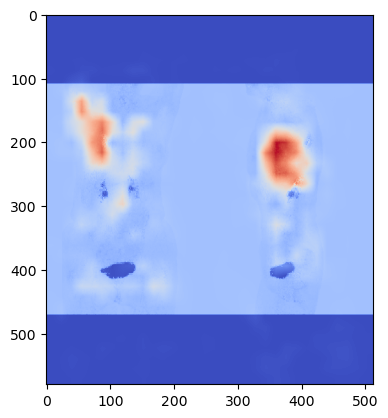

In [56]:
import os

output_path = "/media/andres/T7 Shield1/UCAN_project/Results"
save_path = os.path.join(output_path, pat_id[0])

if not os.path.exists(save_path):
    os.makedirs(save_path)

plt.imshow(overlayed_image, cmap="coolwarm")
#plt.imshow(overlayed_image, cmap="RdYlBu_r")

plt.savefig(save_path + "/overlap.jpg", dpi=400)
#plt.show()
#plt.imshow(i, cmap="gray")

# plt.imshow(i, cmap="gray")
# plt.imshow(overlayed_image, cmap="RdYlBu_r")

# plt.savefig(save_path + "/img.jpg", dpi=400)
print(pat_id)

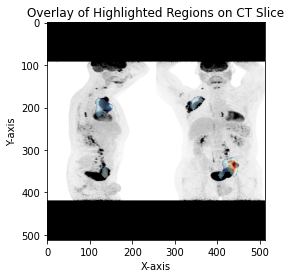

<Figure size 432x288 with 0 Axes>

In [196]:
def overlay_highlighted_regions(ct_slice, highlight_regions, cmap='RdYlBu_r', alpha=0.5):
    """
    Overlay highlighted regions on top of a CT slice.

    Parameters:
        ct_slice (numpy.ndarray): The CT slice array.
        highlight_regions (numpy.ndarray): Array indicating highlighted regions (0 or 1).
        cmap (str, optional): Colormap for the highlighted regions. Default is 'RdYlBu_r'.
        alpha (float, optional): Transparency level of the highlighted regions. Default is 0.5.

    Returns:
        None (displays the plot)
    """
    # Create a figure and axis
    fig, ax = plt.subplots()

    # Display the CT slice
    ax.imshow(ct_slice, cmap='gray')

    # Overlay the highlighted regions
    highlighted_areas = np.ma.masked_where(highlight_regions == 0, highlight_regions)
    ax.imshow(highlighted_areas, cmap=cmap, alpha=alpha)

    # Set labels and title
    ax.set_xlabel('X-axis')
    ax.set_ylabel('Y-axis')
    ax.set_title('Overlay of Highlighted Regions on CT Slice')

    # Show the plot
    plt.show()
    plt.savefig("/media/sambit/HDD/Sambit/Projects/Project_6/Data_Analysis/gradcam-mathod/Output/MTV/img.jpg", dpi=400)


h_new = np.where(h<0.3, 0, h)
overlay_highlighted_regions(i, h_new)

In [122]:
def overlay_gt_on_img(MIP_img, GT):
    temp = np.zeros((MIP_img.shape[0], MIP_img.shape[1], MIP_img.shape[2]))

    mul_gt = np.where(GT == 0, 1, 0)
    add_gt1 = np.where(GT == 0, 0, 125)
    add_gt2 = np.where(GT == 0, 0, 125)

    for i in range(temp.shape[2]):
        temp[:, :, i] = MIP_img[:, :, i] * mul_gt

    # GTs (Green)
    temp[:, :, 1] = temp[:, :, 1] + add_gt1
    temp[:, :, 2] = temp[:, :, 2] + add_gt2

    return temp

def save_MIP(save_path, Data, factor=1.):
    """
    Save the Image using PIL.
    
    save_path - Absolute Path.
    Data - (2D Image) Pixel value should lie between (0,1).
    """
    im = (factor * Data).astype(np.uint8)
    im = Image.fromarray(im).convert('RGB')
    #im = im.resize((4288, 2848))
    im.save(save_path)

MIP_img = (255. * i).astype(np.uint8)
MIP_img = np.asarray(Image.fromarray(MIP_img).convert('RGB'))

h_new = np.where(h<0.4, 0, h)
overlap_img = overlay_gt_on_img(MIP_img, h_new)
path = "/media/sambit/HDD/Sambit/Projects/Project_6/Data_Analysis/gradcam-mathod/Output/MTV/img.jpg"
save_MIP(path, overlap_img)


In [130]:
def overlay_gt_with_gradients(MIP_img, GT, overlay_color=(0, 255, 0)):
    """
    Overlay ground truth on top of an image with gradients of the specified color.

    Parameters:
        MIP_img (numpy.ndarray): The MIP image array.
        GT (numpy.ndarray): Ground truth array with values between 0 and 1.
        overlay_color (tuple, optional): Color for the overlay gradients (RGB values). Default is green.

    Returns:
        overlayed_image (PIL.Image.Image): Overlayed image with gradients.
    """
    # Convert GT to a range of 0-255 for creating gradients
    gt_gradients = (GT * 255).astype(np.uint8)

    # Create a blank RGBA image
    overlayed_image = Image.new('RGBA', MIP_img.shape[:2], (0, 0, 0, 0))

    for i in range(MIP_img.shape[2]):
        # Create a gradient image using GT values and overlay color
        gradient = Image.new('RGBA', MIP_img.shape[:2], (overlay_color[0], overlay_color[1], overlay_color[2], 0))
        for x in range(MIP_img.shape[0]):
            for y in range(MIP_img.shape[1]):
                alpha = gt_gradients[x, y]
                gradient.putpixel((y, x), (overlay_color[0], overlay_color[1], overlay_color[2], alpha))

        # Overlay the gradient on the MIP image
        overlayed_image = Image.alpha_composite(overlayed_image, gradient)

    return overlayed_image

MIP_img = (255. * i).astype(np.uint8)
MIP_img = np.asarray(Image.fromarray(MIP_img).convert('RGB'))

h_new = np.where(h<0.4, 0, h)
overlap_img = overlay_gt_on_img(MIP_img, h_new)
path = "/media/sambit/HDD/Sambit/Projects/Project_6/Data_Analysis/gradcam-mathod/Output/MTV/img.jpg"
save_MIP(path, overlap_img)

In [126]:
np.unique(h_new)

array([0.        , 0.40001383, 0.40005252, ..., 0.96040845, 0.97014505,
       0.9735758 ], dtype=float32)

In [127]:
gt_gradients = (h_new * 255).astype(np.uint8)


In [129]:
np.unique(gt_gradients)

array([  0, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113,
       114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126,
       127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139,
       140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152,
       153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165,
       166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178,
       179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191,
       192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204,
       205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217,
       218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230,
       232, 234, 235, 236, 238, 239, 240, 241, 243, 244, 247, 248],
      dtype=uint8)